# Object detection using Tensorflow API

> 参考：[TensorFlow Object Detection API tutorial](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html)

## 环境配置

In [0]:
!pip install tensorflow_gpu==1.13.2

     |████████████████████████████████| 345.0MB 81kB/s 


In [0]:
import tensorflow as tf

In [0]:
tf.__version__

'1.13.2'

In [0]:
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


In [0]:
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()

In [0]:
!mkdir -p hat-detection/workspace/images
!mkdir -p hat-detection/workspace/annotations
!mkdir -p hat-detection/workspace/pre-trained-model
!mkdir -p hat-detection/workspace/training

In [0]:
!mkdir -p hat-detection/workspace/images/train;mkdir -p hat-detection/workspace/images/test

In [0]:
!mkdir -p hat-detection/addons

## 下载`Tensorflow models`

In [0]:
!cd hat-detection/; git clone https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 29160 (delta 17), reused 9 (delta 5), pack-reused 29130
Receiving objects: 100% (29160/29160), 509.85 MiB | 38.74 MiB/s, done.
Resolving deltas: 100% (18141/18141), done.
Checking out files: 100% (3053/3053), done.


In [0]:
!cd hat-detection/models/research/; protoc object_detection/protos/*.proto --python_out=.

In [0]:
import os
import sys

# 设置models里面的python模块为可搜索
sys.path.append('/content/hat-detection/models/research/')
sys.path.append('/content/hat-detection/models/research/slim')

In [0]:
from object_detection.utils import label_map_util

In [0]:
# 数据集
!cd hat-detection/workspace/images/test; unzip /content/test.zip; cd ../train; unzip /content/test.zip

Archive:  /content//test.zip
  inflating: bdaqm0719_1.jpg         
  inflating: bdaqm0719_1.xml         
  inflating: bdaqm0719_10.jpg        
  inflating: bdaqm0719_10.xml        
  inflating: bdaqm0719_100.jpg       
  inflating: bdaqm0719_100.xml       
  inflating: bdaqm0719_101.jpg       
  inflating: bdaqm0719_101.xml       
  inflating: bdaqm0719_102.jpg       
  inflating: bdaqm0719_102.xml       
  inflating: bdaqm0719_103.jpg       
  inflating: bdaqm0719_103.xml       
  inflating: bdaqm0719_104.jpg       
  inflating: bdaqm0719_104.xml       
  inflating: bdaqm0719_105.jpg       
  inflating: bdaqm0719_105.xml       
  inflating: bdaqm0719_106.jpg       
  inflating: bdaqm0719_106.xml       
  inflating: bdaqm0719_107.jpg       
  inflating: bdaqm0719_107.xml       
  inflating: bdaqm0719_108.jpg       
  inflating: bdaqm0719_108.xml       
  inflating: bdaqm0719_109.jpg       
  inflating: bdaqm0719_109.xml       
  inflating: bdaqm0719_11.jpg        
  inflating: bdaqm071

In [0]:
!ls hat-detection/workspace/images/test/bdaqm0719_100.xml;
!ls hat-detection/workspace/images/train/bdaqm0719_100.xml;

hat-detection/workspace/images/test/bdaqm0719_100.xml
hat-detection/workspace/images/train/bdaqm0719_100.xml


In [0]:
proj_root = '/content/hat-detection/'
tf_model_root = os.path.join(proj_root, 'models')
data_root = os.path.join(proj_root, 'workspace')

## 将数据集转换成`Tensorflow models`指定的格式

### 1. Converting from `*.xml` to `csv`

In [0]:
"""
Usage:
# Create train data:
python xml_to_csv.py -i [PATH_TO_IMAGES_FOLDER]/train -o [PATH_TO_ANNOTATIONS_FOLDER]/train_labels.csv

# Create test data:
python xml_to_csv.py -i [PATH_TO_IMAGES_FOLDER]/test -o [PATH_TO_ANNOTATIONS_FOLDER]/test_labels.csv
"""

import os
import glob
import pandas as pd
import argparse
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    """Iterates through all .xml files (generated by labelImg) in a given directory and combines them in a single Pandas datagrame.

    Parameters:
    ----------
    path : {str}
        The path containing the .xml files
    Returns
    -------
    Pandas DataFrame
        The produced dataframe
    """

    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                    int(root.find('size')[0].text),
                    int(root.find('size')[1].text),
                    member[0].text,
                    int(member[4][0].text),
                    int(member[4][1].text),
                    int(member[4][2].text),
                    int(member[4][3].text)
                    )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df



train_input_dir = os.path.join(data_root, 'images/train')
train_output_path = os.path.join(data_root, 'annotations/train_labels.csv')
test_output_path = os.path.join(data_root, 'annotations/test_labels.csv')
test_input_dir = os.path.join(data_root, 'images/test')
assert(os.path.isdir(train_input_dir))
assert(os.path.isdir(test_input_dir))

train_xml_df = xml_to_csv(train_input_dir)
train_xml_df.to_csv(train_output_path, index=None)
test_xml_df = xml_to_csv(test_input_dir)
test_xml_df.to_csv(test_output_path, index=None)
print('Successfully converted xml to csv.')


Successfully converted xml to csv.


In [0]:
!head -n 2 hat-detection/workspace/annotations/test_labels.csv
!head -n 2 hat-detection/workspace/annotations/train_labels.csv

filename,width,height,class,xmin,ymin,xmax,ymax
bdaqm0719_80.jpg,313,209,hat,191,14,259,91
filename,width,height,class,xmin,ymin,xmax,ymax
bdaqm0719_80.jpg,313,209,hat,191,14,259,91


### 2. Converting from `*.csv` to `*.record`

In [0]:
"""
Usage:

# Create train data:
python generate_tfrecord.py --label=<LABEL> --csv_input=<PATH_TO_ANNOTATIONS_FOLDER>/train_labels.csv  --output_path=<PATH_TO_ANNOTATIONS_FOLDER>/train.record

# Create test data:
python generate_tfrecord.py --label=<LABEL> --csv_input=<PATH_TO_ANNOTATIONS_FOLDER>/test_labels.csv  --output_path=<PATH_TO_ANNOTATIONS_FOLDER>/test.record
"""

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf
import sys
sys.path.append("/home/train/notebook/hat-detection/models/research/")

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

# TO-DO replace this with label map
# for multiple labels add more else if statements
def class_text_to_int(row_label):
    if row_label == 'hat':
        return 1
    # comment upper if statement and uncomment these statements for multiple labelling
    # if row_label == FLAGS.label0:
    #   return 1
    # elif row_label == FLAGS.label1:
    #   return 0
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    # check if the image format is matching with your images.
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

def csv_to_record(output_path, img_path, csv_input):
    writer = tf.python_io.TFRecordWriter(output_path)
    path = os.path.join(os.getcwd(), img_path)
    examples = pd.read_csv(csv_input)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), output_path)
    print('Successfully created the TFRecords: {}'.format(output_path))

csv_to_record(os.path.join(data_root, 'annotations/train.record'),
             os.path.join(data_root, 'images/train'),
             os.path.join(data_root, 'annotations/train_labels.csv'))
csv_to_record(os.path.join(data_root, 'annotations/test.record'),
             os.path.join(data_root, 'images/test'),
             os.path.join(data_root, 'annotations/test_labels.csv'))

Successfully created the TFRecords: /content/hat-detection/workspace/annotations/train.record
Successfully created the TFRecords: /content/hat-detection/workspace/annotations/test.record


In [0]:
!ls -lht hat-detection/workspace/annotations/test.record
!ls -lht hat-detection/workspace/annotations/train.record

-rw-r--r-- 1 root root 51M Aug  6 01:13 hat-detection/workspace/annotations/test.record
-rw-r--r-- 1 root root 51M Aug  6 01:13 hat-detection/workspace/annotations/train.record


### 3. 添加需要检测的目标

In [0]:
with open(os.path.join(data_root, 'annotations/label_map.pbtxt'), 'w') as f:
    f.write("item {\n    id: 1\n    name: 'hat'\n}")

In [0]:
with open(os.path.join(data_root, 'annotations/label_map.pbtxt'), 'r') as f:
    print(f.read())

item {
    id: 1
    name: 'hat'
}


## 准备预训练的模型

In [0]:
!wget -P hat-detection/workspace/pre-trained-model/ https://github.com/tensorflow/models/blob/master/research/object_detection/samples/configs/ssd_inception_v2_coco.config

--2019-08-06 01:14:12--  https://github.com/tensorflow/models/blob/master/research/object_detection/samples/configs/ssd_inception_v2_coco.config
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘hat-detection/workspace/pre-trained-model/ssd_inception_v2_coco.config’

ssd_inception_v2_co     [ <=>                ] 109.57K  --.-KB/s    in 0.08s   

2019-08-06 01:14:12 (1.42 MB/s) - ‘hat-detection/workspace/pre-trained-model/ssd_inception_v2_coco.config’ saved [112200]



In [0]:
!wget -P hat-detection/workspace/pre-trained-model http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2018_01_28.tar.gz

--2019-08-06 01:14:17--  http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.214.128, 2607:f8b0:4001:c05::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.214.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278114232 (265M) [application/x-tar]
Saving to: ‘hat-detection/workspace/pre-trained-model/ssd_inception_v2_coco_2018_01_28.tar.gz’

ssd_inception_v2_co 100%[===================>] 265.23M   156MB/s    in 1.7s    

2019-08-06 01:14:19 (156 MB/s) - ‘hat-detection/workspace/pre-trained-model/ssd_inception_v2_coco_2018_01_28.tar.gz’ saved [278114232/278114232]



In [0]:
!cd hat-detection/workspace/pre-trained-model/; tar zxf *.tar.gz

## 训练模型

### 修改好模型的配置文件
这里使用的是`ssd_inception_v2`这个模型的配置文件

In [0]:
with open(os.path.join(data_root, 'training/ssd_inception_v2_coco.config'), 'r') as f:
    print(f.readline())

# SSD with Inception v2 configuration for MSCOCO Dataset.



### 执行训练
使用`Tensorflow`里面内置的`research/object_detection/legacy/train.py`文件来训练

In [0]:
!cd hat-detection/workspace/; python train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/ssd_inception_v2_coco.config


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use object_detection/model_main.py.
Instructions for updating:
Please switch to tf.train.create_global_step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.batch(batch_size)` (or `padded_batch(...)` if `dynamic_pad=True`).
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.ca

In [0]:
!ls -lht hat-detection/workspace/training

total 1.1G
-rw-r--r-- 1 root root  36M Aug  6 04:44 events.out.tfevents.1565063691.969d45fbe1d8
-rw-r--r-- 1 root root  12M Aug  6 04:44 model.ckpt-2000.meta
-rw-r--r-- 1 root root  269 Aug  6 04:44 checkpoint
-rw-r--r-- 1 root root  53K Aug  6 04:44 model.ckpt-2000.index
-rw-r--r-- 1 root root 202M Aug  6 04:44 model.ckpt-2000.data-00000-of-00001
-rw-r--r-- 1 root root  12M Aug  6 04:34 model.ckpt-1606.meta
-rw-r--r-- 1 root root  53K Aug  6 04:34 model.ckpt-1606.index
-rw-r--r-- 1 root root 202M Aug  6 04:34 model.ckpt-1606.data-00000-of-00001
-rw-r--r-- 1 root root  12M Aug  6 04:24 model.ckpt-1197.meta
-rw-r--r-- 1 root root  53K Aug  6 04:24 model.ckpt-1197.index
-rw-r--r-- 1 root root 202M Aug  6 04:24 model.ckpt-1197.data-00000-of-00001
-rw-r--r-- 1 root root  12M Aug  6 04:14 model.ckpt-786.meta
-rw-r--r-- 1 root root  53K Aug  6 04:14 model.ckpt-786.index
-rw-r--r-- 1 root root 202M Aug  6 04:14 model.ckpt-786.data-00000-of-00001
-rw-r--r-- 1 root root  12M Aug  6 04:04 model.

In [0]:
!rm hat-detection/workspace/training/*

## 导出模型
使用`Tensorflow models`内置的脚本`research/object_detection/export_inference_graph.py`来导出模型

In [0]:
!mkdir -p hat-detection/workspace/trained-inference-graphs;

In [0]:
 rm -rf hat-detection/workspace/trained-inference-graphs/*

In [0]:
!cd hat-detection/workspace/; python3 export_inference_graph.py --input_type image_tensor --pipeline_config_path training/ssd_inception_v2_coco.config --trained_checkpoint_prefix training/model.ckpt-2000 --output_directory trained-inference-graphs/


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
166 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence             0
-step                       -1
-order_by                   name
-account_type_regexes       _trainable_variables
-

In [0]:
!ls -lht hat-detection/workspace/trained-inference-graphs/

total 103M
-rw-r--r-- 1 root root 4.2K Aug  6 05:16 pipeline.config
drwxr-xr-x 3 root root 4.0K Aug  6 05:16 saved_model
-rw-r--r-- 1 root root  51M Aug  6 05:16 frozen_inference_graph.pb
-rw-r--r-- 1 root root 1.6M Aug  6 05:16 model.ckpt.meta
-rw-r--r-- 1 root root   77 Aug  6 05:16 checkpoint
-rw-r--r-- 1 root root  18K Aug  6 05:16 model.ckpt.index
-rw-r--r-- 1 root root  51M Aug  6 05:16 model.ckpt.data-00000-of-00001


In [0]:
!rm trained-inference-graphs.tar.gz

In [0]:
!tar zcf trained-inference-graphs.tar.gz hat-detection/workspace/trained-inference-graphs/

## 测试导出的模型

In [0]:
import os
import sys
import tensorflow as tf
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import numpy as np
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [0]:
MODEL_PATH = os.path.join(proj_root, 'workspace/trained-inference-graphs/frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(proj_root, 'workspace/annotations/label_map.pbtxt')

# Number of classes to detect
NUM_CLASSES = 1

In [0]:
print('Model path:', MODEL_PATH)
assert os.path.exists(MODEL_PATH)
print('Label path:', PATH_TO_LABELS)
assert os.path.exists(PATH_TO_LABELS)

Model path: /content/hat-detection/workspace/trained-inference-graphs/frozen_inference_graph.pb
Label path: /content/hat-detection/workspace/annotations/label_map.pbtxt


In [0]:
!cat /content/hat-detection/workspace/annotations/label_map.pbtxt

item {
    id: 1
    name: 'hat'
}

In [0]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [0]:
print(category_index)

{1: {'id': 1, 'name': 'hat'}}


In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(MODEL_PATH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [0]:
test_img = '/content/hat-detection/workspace/images/test/bdaqm0719_100.jpg'

In [0]:
!ls /content/hat-detection/workspace/images/test/bdaqm0719_100.jpg

/content/hat-detection/workspace/images/test/bdaqm0719_100.jpg


In [0]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

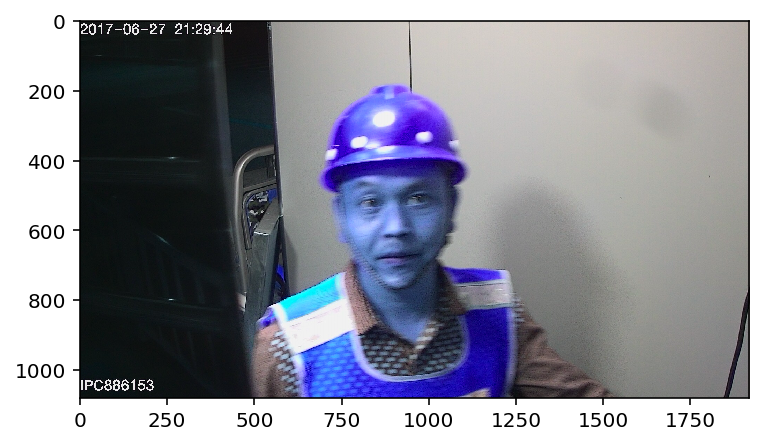

In [0]:
plt.imshow(cv2.imread(test_img))

In [0]:
image_np = cv2.imread(test_img)
image_np.size

6220800

In [0]:
from PIL import ImageDraw, Image

In [0]:
img = Image.fromarray(np.uint8(image_np)).convert('RGB')

In [0]:
img.size

(1920, 1080)

In [0]:
draw = ImageDraw.Draw(img)

boxes: [[0.16302434 0.35073054 0.7242646  0.5867831 ]
 [0.         0.         0.1591635  0.25949165]
 [0.4517131  0.23326105 0.6696596  0.73537666]
 [0.7590711  0.56346416 1.         0.92767465]
 [0.7802012  0.         1.         0.35206094]]
class: [1. 1. 1. 1. 1.]
scores: [0.999964   0.00433835 0.00333902 0.00256902 0.00251713]


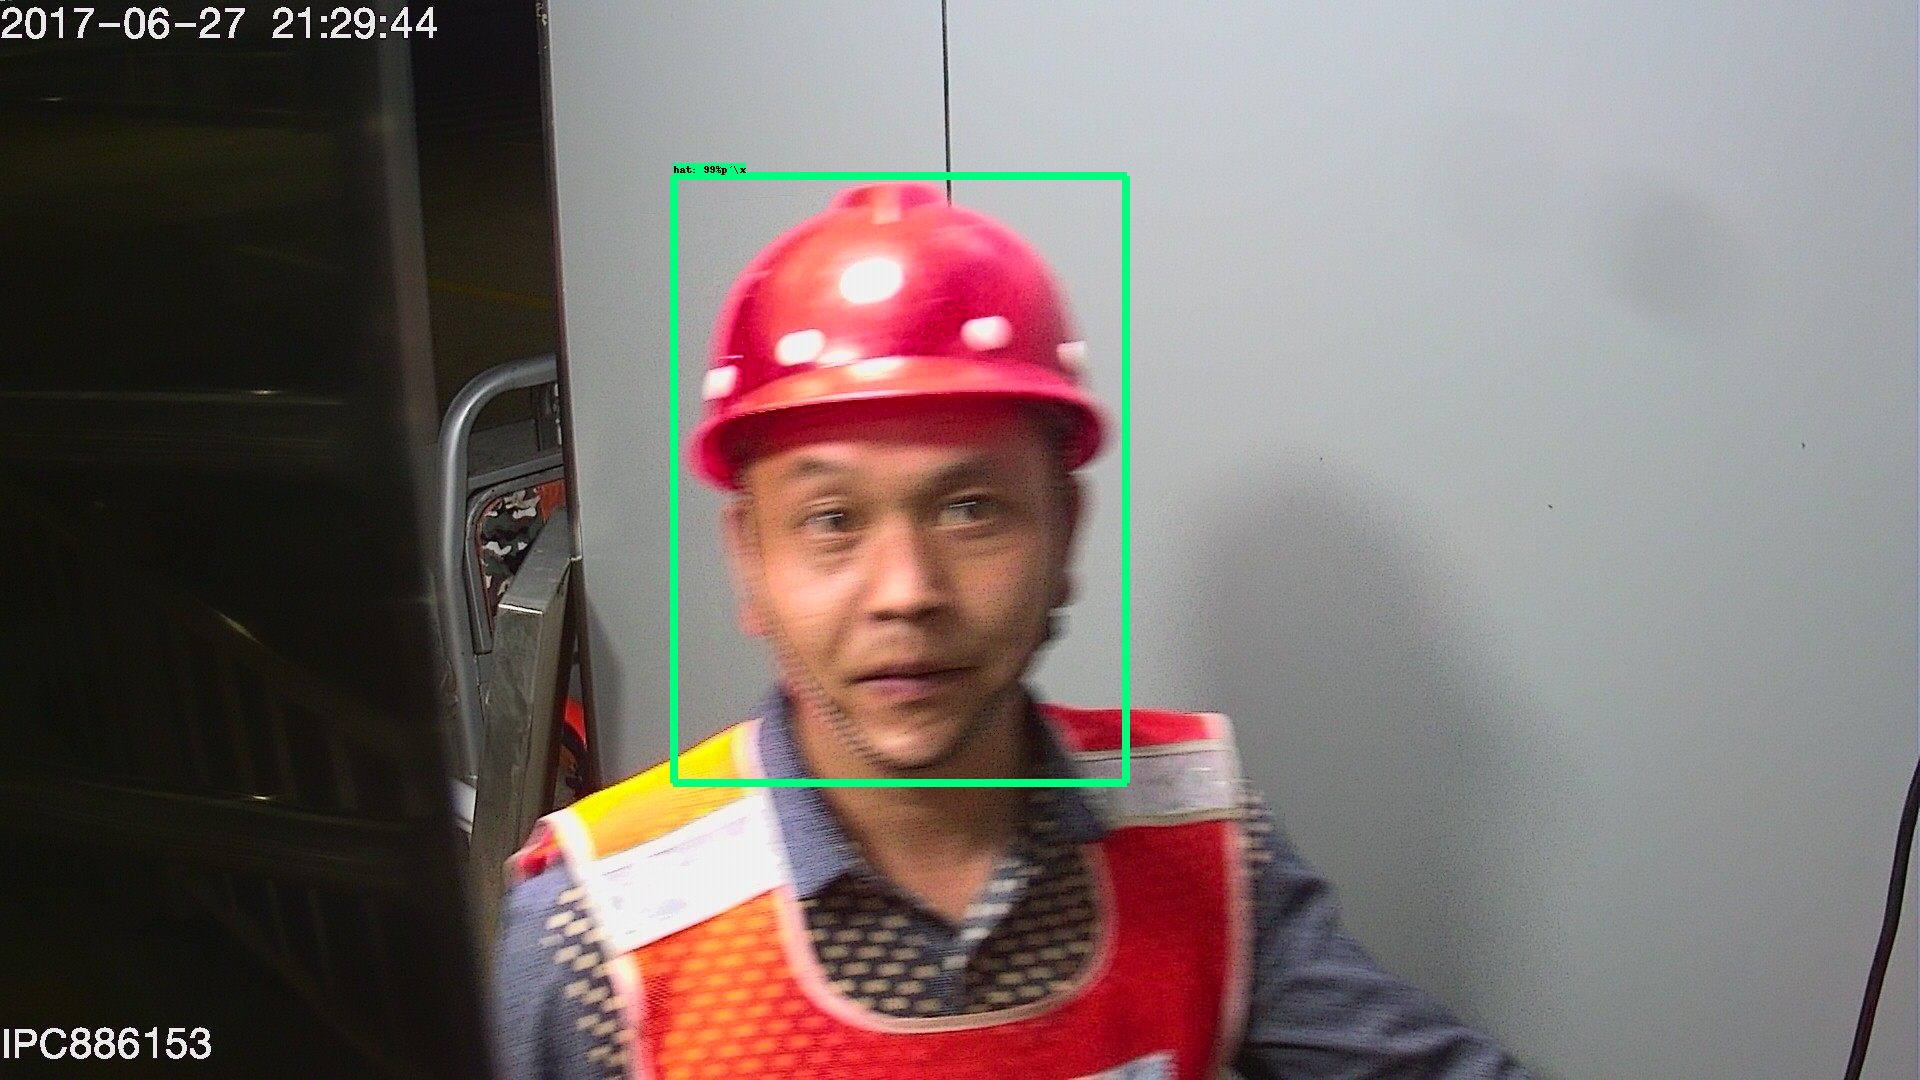

In [0]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Read frame from camera
#         ret, image_np = cap.read()
        image_np = cv2.imread(test_img)
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Extract image tensor
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Extract detection boxes
        boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Extract detection scores
        scores = detection_graph.get_tensor_by_name('detection_scores:0')
        # Extract detection classes
        classes = detection_graph.get_tensor_by_name('detection_classes:0')
        # Extract number of detectionsd
        num_detections = detection_graph.get_tensor_by_name(
            'num_detections:0')
        # Actual detection.
        (boxes, scores, classes, num_detections) = sess.run(
            [boxes, scores, classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        # Visualization of the results of a detection.
        print('boxes:', boxes[0, :5])
        print('class:', classes[0, :5])
        print('scores:', scores[0, :5])
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.squeeze(boxes[:5]),
            np.squeeze(classes[:5]).astype(np.int32),
            np.squeeze(scores[:5]),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=8)

        # Display output
        cv2_imshow(image_np)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   35G  306G  11% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
tmpfs           6.4G   12K  6.4G   1% /var/colab
/dev/sda1       365G   41G  325G  12% /opt/bin
shm             6.0G  4.0K  6.0G   1% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  8.7G  6.4G  58% /content/drive


In [0]:
!mkdir -p drive/My\ Drive/my-projects/object-detection-tf-api

In [0]:
!cp test.zip drive/My\ Drive/my-projects/object-detection-tf-api